# Main Analysis

In [78]:
# Step 1: Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt

import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [79]:
# Read in the data
df = pd.read_csv('data/data.csv')

# Make a copy of the original dataframe
df_copy = df.copy()

In [80]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import altair as alt

def add_year_of_game(data):
    data['YearOfgame'] = data['date'].apply(lambda x: x.split('-')[0])
    return data

def count_na_values(data):
    na = [(index, data[col].isna().sum()) for index, col in enumerate(data)]
    return len([x[1] for x in na if x[1] > 0])

def impute_missing_values(data, features, imp_features, imp_stance):
    for feature in features:
        data[feature] = imp_features.fit_transform(data[feature].values.reshape(-1, 1))
    data['R_Stance'] = imp_stance.fit_transform(data['R_Stance'].values.reshape(-1, 1))
    data['B_Stance'] = imp_stance.fit_transform(data['B_Stance'].values.reshape(-1, 1))
    return data

def impute_mean_values(data, na, imp_stance):
    for x in na:
        if x[1] > 0 and data.iloc[:, x[0]].dtype != 'object':
            data.iloc[:, x[0]] = imp_stance.fit_transform(data.iloc[:, x[0]].values.reshape(-1, 1))
    return data

# Read in the data
df = pd.read_csv('data/data.csv')

# Make a copy of the original dataframe
df_copy = df.copy()

# Calculate year-wise games
play_info = df
play_info = add_year_of_game(play_info)
play_counts = pd.DataFrame(play_info['YearOfgame'].value_counts().sort_index())
play_counts['NoOfGames'] = play_counts['YearOfgame']
play_counts['YearOfgame'] = play_counts.index

# Calculate games in each weight class
weightClassCount = pd.DataFrame(df['weight_class'].value_counts())
weightClassCount['WeightClass'] = weightClassCount.index

# Deal with null values
print('Number of features with NaN values:', count_na_values(df))

# Impute missing values
imp_features = ['R_Weight_lbs', 'R_Height_cms', 'B_Height_cms', 'R_age', 'B_age', 'R_Reach_cms', 'B_Reach_cms']
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_stance = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

df = impute_missing_values(df, imp_features, imp_median, imp_stance)
df_copy = impute_missing_values(df_copy, imp_features, imp_median, imp_stance)

# Impute mean values
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
na = [(index, df[col].isna().sum()) for index, col in enumerate(df)]

df = impute_mean_values(df, na, imp_mean)
df_copy = impute_mean_values(df_copy, na, imp_mean)

df = df.drop(['Referee'], axis=1)

print('Number of features with NaN values:', count_na_values(df))

# Exploratory Data Analysis
winnerCounts = df['Winner'].value_counts().reset_index()
winnerCounts['whoWon'] = winnerCounts['index']
winnerCounts = winnerCounts.sort_values(by="whoWon")


base = alt.Chart(winnerCounts).mark_arc(innerRadius=3).encode(
    theta=alt.Theta(field="Winner", type="quantitative"),
    color=alt.Color(field="whoWon", type="nominal")).properties(width=800)

c1 = base.mark_arc(innerRadius=2, stroke="#fff")

c2 = base.mark_text(radius=100, size=20,radiusOffset=80).encode(text="Winner:N")



# Number of Games
playCountsBar=alt.Chart(play_counts).mark_bar(color="lightblue").encode(x='YearOfgame',y='NoOfGames').properties(width=990)

playCountsBarText = playCountsBar.mark_text(baseline='middle',dx=4).encode(text='NoOfGames')

(playCountsBar  + playCountsBarText)


# Winner of the Game
df['YearOfgame'] = df['date'].apply(lambda x : x.split('-')[0])
playWinner = df.groupby('YearOfgame')['Winner'].value_counts().reset_index(name='NoOfGames')


alt.Chart(playWinner).mark_area(opacity=0.5).encode(x='YearOfgame',y='NoOfGames',color='Winner').properties( width=890,title='Winner of the Game')




Number of features with NaN values: 109
Number of features with NaN values: 0


alt.Chart(...)

Test Accuracy of Random Forest :  0.6779233870967742
Test Accuracy of XGBoost :  0.6628024193548387
Sample Mean: 0.01415070203288995
Sample Standard Deviation: 0.008351864704352813
T-statistic: 3.788606831525336


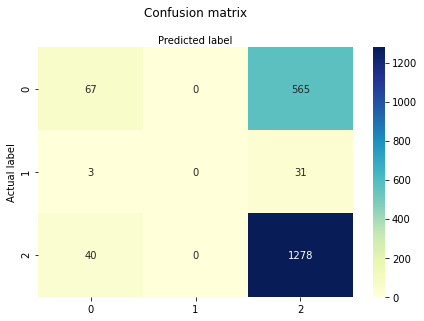

In [81]:
def fill_na_mode(data, columns):
    for column in columns:
        data[column] = data[column].fillna(data[column].mode()[0])
    return data


def label_encode_columns(data, column_pairs):
    for col1, col2 in column_pairs:
        label_encoder = LabelEncoder()
        label_encoder.fit(list(set(list(data[col1].values) + list(data[col2].values))))
        data[col1] = label_encoder.transform(data[col1])
        data[col2] = label_encoder.transform(data[col2])
    return data


def drop_unrelated_columns(data, columns):
    return data.drop(columns, axis=1)


df = fill_na_mode(df, ['B_Stance', 'R_Stance', 'weight_class'])

df = label_encode_columns(df, [('R_Stance', 'B_Stance'), ('R_fighter', 'B_fighter')])

# Encoding 'weight_class' separately since it has no paired column
label_encoder_weight_class = LabelEncoder()
df['weight_class'] = label_encoder_weight_class.fit_transform(df['weight_class'])

# Dropping unrelated columns
target_variable = df['Winner']
input_variables = drop_unrelated_columns(df, ['title_bout', 'location', 'date', 'Winner', 'YearOfgame'])

# Label Encoding Target Variable
label_encoder_winner = LabelEncoder()
target_variable = label_encoder_winner.fit_transform(target_variable)

# Test Train Split
X_train, X_test, y_train, y_test = train_test_split(input_variables, target_variable, test_size=0.33, random_state=42)

# Modelling
model = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Test Accuracy of Random Forest : ", model.score(X_test, y_test))

# We use cross-validation with 5-folds to have a more precise accuracy (reduce variation)
acc_random = cross_val_score(estimator=model, X=X_train, y=y_train, cv=5)

# Confusion Matrix
class_names = [0, 1, 2]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
cm2 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm2, annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

sorted_idx = model.feature_importances_.argsort()
feature_imp = pd.DataFrame(columns=['Variables', 'Importance'])
feature_imp['Variables'] = list(input_variables.columns[sorted_idx])
feature_imp['Importance'] = list(model.feature_importances_[sorted_idx])
feature_imp = feature_imp.sort_values(by='Importance', ascending=False)[:10]
feature_imp

# XgBoost
model = XGBClassifier()
model.fit(X_train, y_train)

print("Test Accuracy of XGBoost : ", model.score(X_test, y_test))

# We use cross-validation with 5-folds to have a more precise accuracy (reduce variation)
acc_xgboost = cross_val_score(estimator=model, X=X_train, y=y_train, cv=5)

t = pd.DataFrame([acc_random, acc_xgboost],
                 columns=['1st Fold', '2nd Fold', '3rd Fold', '4th Fold', '5th Fold'],
                 index=['Random Forest', 'XGBoost'])
t

diff_in_accuracy = []
for i in range(len(t.columns)):
    diff_in_accuracy.append(t.iloc[0, i] - t.iloc[1, i])

sample_mean = sum(diff_in_accuracy) / len(t.columns)
print("Sample Mean:", sample_mean)

sample_std = np.sqrt(sum([np.square(np.subtract(i, sample_mean)) for i in diff_in_accuracy]) / (len(t.columns) - 1))
print("Sample Standard Deviation:", sample_std)

t_statistic = (np.sqrt(len(t.columns)) * sample_mean) / sample_std
print("T-statistic:", t_statistic)